In [1]:
import os
import warnings
import time
from copy import deepcopy

import numpy as np 

from scipy.stats import chisquare
from scipy.interpolate import interp1d

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std, gaussian_sigma_to_fwhm
from astropy.table import Table
from astropy.modeling import models, fitting, functional_models, Parameter, custom_model
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.utils.exceptions import AstropyWarning
from astropy import units as u
from astropy.convolution import convolve
from astropy import units as u 
from astropy.nddata import CCDData, Cutout2D

from astropy.stats import gaussian_fwhm_to_sigma

from photutils import detect_threshold
from photutils import deblend_sources
from photutils import source_properties
from photutils import detect_sources
from photutils import source_properties, EllipticalAperture

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.stats import SigmaClip

from photutils import Background2D, MedianBackground
from photutils import DAOStarFinder
from photutils import aperture_photometry, CircularAperture, CircularAnnulus, EllipticalAnnulus

In [2]:
from lcbg.utils import cutout, measure_fwhm, plot_apertures, angular_to_pixel
from lcbg.fitting import plot_fit, fit_model, model_subtract, Moffat2D, Nuker2D
from lcbg.segmentation import plot_segment_residual, plot_segments, make_segments, deblend_segments, segm_mask, masked_segm_image
from lcbg.photometry import flux_to_abmag, order_cat
from lcbg.cosmology import cosmo_aperture_diameter


In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['figure.figsize'] = [12, 12]

In [4]:
import ipywidgets as widgets
from IPython.display import display

# Define Paths

In [5]:
filter_list = ['f105w', 'f125w', 'f140w', 'f160w']

In [6]:
input_data_formatter = "https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0-epoch1/hlsp_frontier_hst_wfc3-60mas_abell2744_{}_v1.0_drz.fits"

# Do Aperture Photomerty

In [7]:
current_filter =  filter_list[0]
input_data_path = input_data_formatter.format(current_filter)
output_path = "{}_catalog.csv".format(os.path.splitext(os.path.basename(input_data_path))[0])

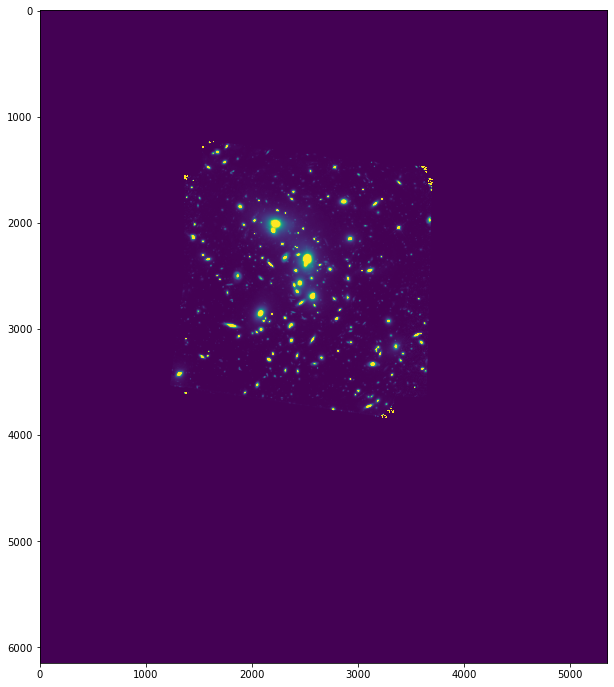

In [8]:
# Load data and vitals
# ---------------------
data = CCDData.read(input_data_path)

plt.imshow(data, vmin=0, vmax=data.data.mean()*10)

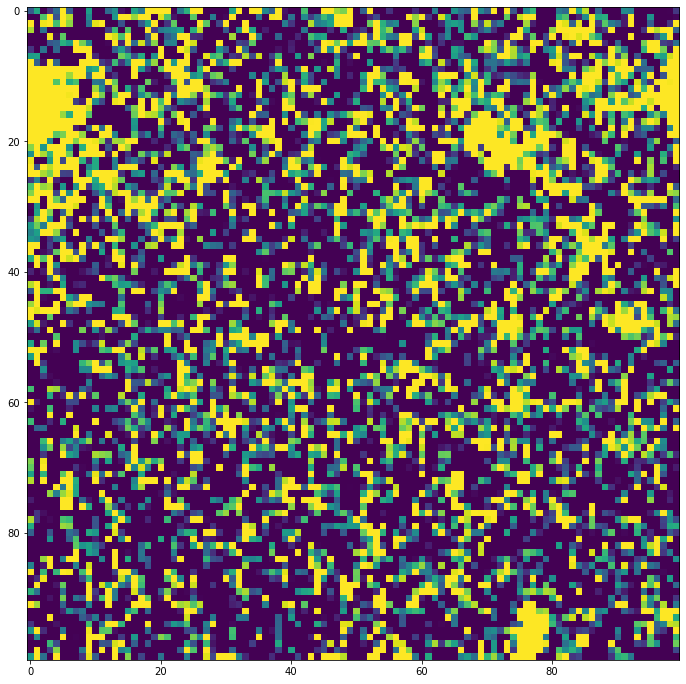

In [9]:
# Estimate data noise at dark area
# --------------------------------
noise_cutout = Cutout2D(data, (2779, 3390), 100)

noise_mean = noise_cutout.data.mean()
noise_3_sigma = np.unique(detect_threshold(noise_cutout.data, nsigma=3))[0] # Single value
noise_8_sigma = np.unique(detect_threshold(noise_cutout.data, nsigma=8))[0] # Single value

plt.imshow(noise_cutout.data, vmax=noise_cutout.data.mean()*10, vmin=0)

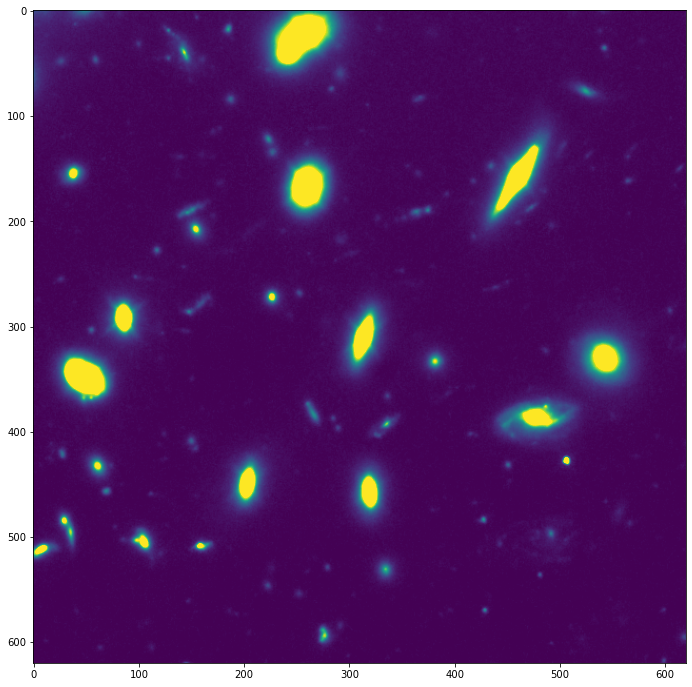

In [10]:
# Cutout Image
# -------------
# Select and crop image:
# Center of cluster:
#cx, cy = [int(np.round(i)) for i in data.wcs.world_to_pixel_values(data.header["RA_TARG"], data.header["DEC_TARG"])]
#size = 2000

# Cutom center:
# cx, cy, size = 2864, 3563, 100 # Small faint group of galaxies
cx, cy, size = 2418, 3254, 620 # Larger group of galaxies

image = Cutout2D(data, (cx, cy), size)
image.data -= noise_mean
image.data = np.clip(image.data, 0, image.data.max())

vmin = 0
vmax = image.data.mean()*10

plt.imshow(image.data, vmin=vmin, vmax=vmax)

Num of Targets: 105


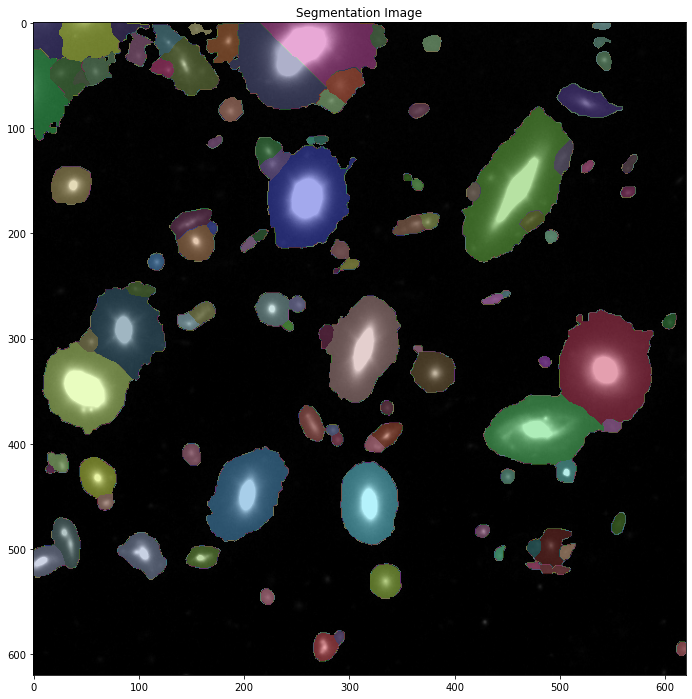

In [11]:
# Catalog
# -------

# Define detect threshold
#nsigma = image.data.mean() 
nsigma = noise_3_sigma
#nsigma = noise_8_sigma
#nsigma = np.unique(detect_threshold(image.data, nsigma=3))[0]

# Make segmentation map
kernel_size=10
segm = make_segments(image.data, nsigma=nsigma, kernel_size=kernel_size, fwhm=5, npixels=10**2)

# Deblend segmentation map
segm_deblend = deblend_segments(image.data, segm, contrast=0, kernel_size=kernel_size, fwhm=5, npixels=10)

# Remove border sources
#segm_deblend.remove_border_labels(100)

# Make catalog
cat = source_properties(image.data, segm_deblend, wcs=image.wcs)
print("Num of Targets:", len(cat))

plot_segments(segm_deblend, image.data, vmin=vmin, vmax=vmax)
plt.show()



In [12]:
# Test out masked_segm_image
def slider(x):
    plt.imshow(masked_segm_image(cat[x], image, segm_deblend).data, vmin=vmin, vmax=vmax)
    plt.show()

widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(cat)-1));

interactive(children=(BoundedIntText(value=0, description='x', max=104), Output()), _dom_classes=('widget-inte…

In [13]:
# List of radii
# -------------
r_list = list(range(1, 151, 5))
#r_list = np.logspace(np.log10(0.06),np.log10(14), 10) * u.arcsec # approximate isophotal extent
#r_list = angular_to_pixel(r_list, wcs=image.wcs) # convert to pixels
#r_list = np.unique(np.round(r_list).astype(int)) # convert to int 

print("max=", r_list[-1])
print("len=", len(r_list))

max= 146
len= 30


In [14]:
def photometry_step(obj, r_list, image, segm_deblend, plot=False, subtract_bg=True, return_areas=False):
    """
    # Inputs if using cell mode (commenting out the function def and unindent)
    obj = cat[0]
    plot = True
    subtract_bg = True 
    """

    # Load full image mask
    mask = segm_mask(obj, segm_deblend)

    # Center of object
    # x, y = obj.xcentroid.value, obj.ycentroid.value
    x, y = obj.maxval_xpos.value, obj.maxval_ypos.value

    position = np.transpose((x, y))

    obj_e = obj.elongation.value
    obj_theta = obj.orientation.to(u.rad).value

    # Estimate background
    bg_density = None 
    if subtract_bg:
        max_a = max(r_list)
        max_b = max_a / obj_e

        annulus_inner = 1 # inner ring multiplier
        annulus_outter = (max_a+2)/max_a # outter ring multiplier

        annulus = EllipticalAnnulus(position, 
                                    max_a*annulus_inner, 
                                    max_a*annulus_outter, 
                                    max_b*annulus_outter, 
                                    theta=obj_theta) 
        
        annulus_mask = annulus.to_mask().multiply(mask)
        annulus_area = annulus_mask.sum()
        bg_density = (annulus.do_photometry(image.data, mask=np.invert(mask))[0][0] / annulus.area)

    masked_image = masked_segm_image(obj, image, segm_deblend, fill=noise_mean)

    aperture_photometry_row = []
    aperture_area_row = []

    if plot:
        f, ax = plt.subplots(1, 1)
        ax.imshow(masked_image.data, vmax=image.data.mean())
    for i, r in enumerate(r_list):
        
        a = r
        b = a / obj_e
        
        aperture = EllipticalAperture(position, a, b, theta=obj_theta)
        aperture_area = (aperture.to_mask().multiply(masked_image.data > 0)).sum()


        masked_image = masked_segm_image(obj, image, segm_deblend, fill=noise_mean)
        photometric_sum = aperture.do_photometry(masked_image.data)[0][0]

        photometric_value = photometric_sum 

        if subtract_bg:
            photometric_bkg = aperture_area * noise_mean
            photometric_value -= photometric_bkg
        if np.isnan(photometric_value):
            raise Exception("Nan photometric_value")
        if plot:
            aperture.plot(ax, color='r')
            
        aperture_photometry_row.append(photometric_value)
        aperture_area_row.append(aperture_area)

    if plot:
        if subtract_bg:
            annulus.plot(ax, color='w', linestyle='--')
        plt.show()
        
    if return_areas:
        return aperture_photometry_row, aperture_area_row
    else:
        return aperture_photometry_row

In [15]:
# Test photometry function
def slider(x):
    obj = cat[x]
    print(obj.id)
    aperture_photometry_row = photometry_step(obj, r_list, image, segm_deblend, plot=True, subtract_bg=True)
    plt.plot(range(len(r_list)), aperture_photometry_row)

    for i in range(len(r_list)):
        plt.axvline(i)
    plt.show()


widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(cat)-1));

interactive(children=(BoundedIntText(value=0, description='x', max=104), Output()), _dom_classes=('widget-inte…

In [16]:
# Photomerty
# ----------
pb = widgets.IntProgress(
    value=0,
    min=0,
    max=len(cat),
    step=1,
    description='Loading:',
    bar_style='',
    orientation='horizontal'
)
display(pb)

single_aperture_photometry_table = cat.to_table()

aperture_photometry_rows = []
aperture_area_rows = []
for idx, obj in enumerate(cat):
    pb.value = idx + 1
    pb.description = "{}/{}".format(pb.value, len(cat))
    
    aperture_photometry_row, aperture_area_row = photometry_step(obj, r_list, image, segm_deblend, plot=False, subtract_bg=True, return_areas=True)
    aperture_photometry_rows.append(np.array(aperture_photometry_row))
    aperture_area_rows.append(aperture_area_row)
    
single_aperture_photometry_table.add_columns(np.transpose(aperture_photometry_rows), names=["aperture_sum_{:0>3}".format(r) for r in r_list])
single_aperture_photometry_table.add_columns(np.transpose(aperture_area_rows), names=["aperture_area_{:0>3}".format(r) for r in r_list])
single_aperture_photometry_table.sort(keys="source_sum", reverse=1)
single_aperture_photometry_table.write(output_path, format="ascii.csv", overwrite=True)
plt.show()

IntProgress(value=0, description='Loading:', max=105)

In [17]:
result_cat = Table.read(output_path)
result_cat.sort(keys="source_sum", reverse=1)
result_cat

id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,min_value,max_value,minval_xpos,minval_ypos,maxval_xpos,maxval_ypos,area,equivalent_radius,perimeter,semimajor_axis_sigma,semiminor_axis_sigma,orientation,eccentricity,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy,gini,aperture_sum_001,aperture_sum_136,aperture_sum_131,aperture_sum_126,aperture_sum_121,aperture_sum_116,aperture_sum_111,aperture_sum_106,aperture_sum_101,aperture_sum_096,aperture_sum_091,aperture_sum_086,aperture_sum_081,aperture_sum_076,aperture_sum_071,aperture_sum_066,aperture_sum_061,aperture_sum_056,aperture_sum_051,aperture_sum_046,aperture_sum_041,aperture_sum_036,aperture_sum_031,aperture_sum_026,aperture_sum_021,aperture_sum_016,aperture_sum_011,aperture_sum_006,aperture_sum_141,aperture_sum_146,aperture_area_001,aperture_area_136,aperture_area_131,aperture_area_126,aperture_area_121,aperture_area_116,aperture_area_111,aperture_area_106,aperture_area_101,aperture_area_096,aperture_area_091,aperture_area_086,aperture_area_081,aperture_area_076,aperture_area_071,aperture_area_066,aperture_area_061,aperture_area_056,aperture_area_051,aperture_area_046,aperture_area_041,aperture_area_036,aperture_area_031,aperture_area_026,aperture_area_021,aperture_area_016,aperture_area_011,aperture_area_006,aperture_area_141,aperture_area_146
int64,float64,float64,str38,str38,float64,str4,str4,str4,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
72,48.157082985757874,347.76795980676235,"3.5932727659002204,-30.384378443254207","3.593269732408755,-30.38438061961816",749.7831,None,None,None,None,9.0,94.0,303.0,391.0,0.0008333084,6.0272384,26.0,374.0,48.0,348.0,4922.0,39.581829919757595,282.5990257669732,9.610002717432511,7.768979312790166,38.032135373678145,0.5885973621426442,0.1915736611918678,1.2369710782485217,80.20734062465415,15.52669207171499,72.50185116696768,0.013006910276914623,-0.0055710105996877,0.014389283394326862,0.8138703507864498,14.259426773537156,783.202341039861,780.8951842789337,778.6104557364599,776.5917023420903,774.6694180236015,772.9138495666533,771.0307390664434,769.2702797128129,767.8799118247455,766.4169131838793,764.8975630429157,763.4747063416936,761.9994437740594,760.3884802077243,758.6105592683821,756.9447004101823,755.1040070223563,752.9166963461136,749.9368301925929,745.5709139788485,739.0737676464286,728.1994042011897,707.2832217465962,664.04785760096,579.5989104458414,446.5500030089374,256.09410059287455,785.3196915901733,787.647635053643,2.5397462469681207,30014.652885215135,28474.814804693335,26908.36709521132,25373.017233814888,23844.51081730996,22347.301521911282,20858.467829337897,19420.652851122817,17985.748759582413,16577.181591285214,15207.462239493752,13873.088877387723,12617.626859633277,11384.164374315134,10165.850844053377,8987.128704105207,7797.648818923888,6573.295669361629,5368.638808587695,4269.313441153412,3291.511136070685,2440.6961433363645,1716.86846295045,1120.0280949129415,650.175039223839,307.3092958831427,91.43086489085238,31623.37706427319,33313.793802871194
43,260.0543571215096,19.91425880307983,"3.5891791835578477,-30.389842884283556","3.5891761507025746,-30.389845061052984",727.69116,None,None,None,None,215.0,325.0,0.0,61.0,0.00081788

In [18]:
import re

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

mag_col_names = natural_sort([i for i in result_cat.colnames if "aperture_sum_" in i])
area_col_names = natural_sort([i for i in result_cat.colnames if "aperture_area_" in i])

In [23]:
def calculate_circle_petrosian(phot_values, r_list):
    
    petrosian_list = []
    
    last_r = 0
    last_I = 0
    for i in range(len(r_list)):
        r = r_list[i]
        I = phot_values[i]
        
        area_of_slice = (np.pi * (r**2 - last_r**2))
        I_at_r = (I - last_I) / area_of_slice 
        
        area_within_r = (np.pi * r**2)
        I_avg_within_r = (I / area_within_r)

        petrosian_value = I_at_r / I_avg_within_r
        
        petrosian_list.append(petrosian_value)
        
        last_r = r
        last_I = I 
        
    return petrosian_list


def calculate_petrosian(phot_values, area_list):

    petrosian_list = []
    
    last_area = 0
    last_I = 0
    for i in range(len(r_list)):
        area = area_list[i]
        I = phot_values[i]
        
        area_of_slice = area - last_area
        I_at_r = (I - last_I) / area_of_slice 
        
        area_within_r = area
        I_avg_within_r = (I / area_within_r)

        petrosian_value = I_at_r / I_avg_within_r
        
        petrosian_list.append(petrosian_value)
        
        last_area = area
        last_I = I
        
    return petrosian_list

def elliptical_area_to_r(area, e):
    a = np.sqrt(e * area / (np.pi))
    b = a / e 
    return a, b

def circle_area_to_r(area):
    return np.sqrt(area / (np.pi))


def compute_petrosian_r(area_list, flux_list, eta=0.2, e=1.):
    
    petrosian_list = calculate_petrosian(flux_list, area_list)
    f = interp1d(area_list, petrosian_list, kind='cubic')

    area_list_new = np.linspace(min(area_list), max(area_list), num=1000, endpoint=True)

    cutoff_idx = np.where((area_list_new <= max(area_list)) & (area_list_new >= min(area_list)))[0]
    area_list_new = area_list_new[cutoff_idx]

    petrosian_list_new = f(area_list_new)
    
    idx_list = np.where(petrosian_list_new <= eta)[0]
    
    r_petrosian = None
    if idx_list.size > 0:
        idx =  idx_list[0] 
        r_petrosian = elliptical_area_to_r(area_list_new[idx], e=e)[0]
        
    return r_petrosian

In [20]:
def slider(x):
    row = result_cat[x]
    obj = cat[row['id']-1]
    assert obj.id == row['id']
    masked_image = masked_segm_image(obj, image, segm_deblend)
    
    obj_e = obj.elongation.value
    obj_theta = obj.orientation.to(u.rad).value
    
    size = max(r_list)
    x, y = row['maxval_xpos'], row['maxval_ypos']
    
    # Plot Target
    # -----------
    
    f, ax = plt.subplots(2, 2)

    ax[0,0].imshow(image.data, vmin=vmin, vmax=vmax)
    ax[0,0].set_xlim(x-size, x+size)
    ax[0,0].set_ylim(y-size, y+size)
    ax[0,0].set_title("Target {}".format(row['id']))
    
    ax[0,1].imshow(masked_image.data, vmin=vmin, vmax=vmax)
    ax[0,1].set_xlim(x-size, x+size)
    ax[0,1].set_ylim(y-size, y+size)
    ax[0,1].set_title("Target [Masked Image]")    
    
    position = [x, y]
    
    for r in r_list:
        a = r
        b = a / obj_e
        aperture = EllipticalAperture(position, a, b, theta=obj_theta)
        aperture.plot(ax[0,0], color='r')
        aperture.plot(ax[0,1], color='r')
    
    max_a = max(r_list)
    max_b = max_a / obj_e

    annulus_inner = 1 # inner ring multiplier
    annulus_outter = (max_a+2)/max_a # outter ring multiplier

    annulus = EllipticalAnnulus(position, 
                                max_a*annulus_inner, 
                                max_a*annulus_outter, 
                                max_b*annulus_outter, 
                                theta=obj_theta) 
    
    annulus.plot(ax[0,0], color='w')
    annulus.plot(ax[0,1], color='w')


    # Plot Cumulative Photometry
    # --------------------------
    
    y_values = list(row[mag_col_names])
    ax[1,0].plot(r_list, y_values, label="Raw")
    
    ax[1,0].set_title("Cumulative Photometry")
    ax[1,0].set_xlabel("Aperture Radius [Pix]")
    ax[1,0].set_ylabel("Photometic Sum")
    
    ax[1,0].legend()
    
    # Plot Photometic Density
    # -----------------------
    
    y_values = []
    phot_values = list(row[mag_col_names])
    for i in range(len(r_list)):
        if i == 0:
            y_values.append(phot_values[i]/(np.pi*r_list[i]**2))
            continue
        y_values.append((phot_values[i] - phot_values[i-1])/(np.pi*(r_list[i]**2 - r_list[i-1]**2)))    
    ax[1,1].plot(r_list, y_values, label="Raw") 
  
    ax[1,1].set_title("Photometic Density: sum(slice) / area(slice)")
    ax[1,1].set_xlabel("Aperture Radius [Pix]")
    ax[1,1].set_ylabel("Photometic Density")
    ax[1,1].axhline(0, c='black', label="Zero Level")
    ax[1,1].legend()
    
    plt.show()
    
    
    petrosian_number = 0.2
    
    area_list = np.array(list(row[area_col_names]))
    flux_list = np.array(list(row[mag_col_names]))
    petrosian_list = calculate_petrosian(flux_list, area_list)
    f = interp1d(area_list, petrosian_list, kind='cubic')

    r_list_new = np.linspace(min(r_list), max(r_list), num=1000, endpoint=True)
    area_list_new = np.pi * r_list_new**2 / obj_e

    cutoff_idx = np.where((area_list_new <= max(area_list)) & (area_list_new >= min(area_list)))[0]
    r_list_new = r_list_new[cutoff_idx]
    area_list_new = area_list_new[cutoff_idx]

    petrosian_list_new = f(area_list_new)

    plt.plot(elliptical_area_to_r(area_list, obj_e)[0], petrosian_list, 'o', r_list_new, petrosian_list_new, '-')

    idx_list = np.where(petrosian_list_new <= petrosian_number)[0]

    r_petrosian = 0
    if idx_list.size > 0:
        idx =  idx_list[0] 
        r_petrosian = r_list_new[idx]
        plt.axvline(r_petrosian, linestyle='--')
        plt.axhline(petrosian_list_new[idx], xmax=r_petrosian or 1, linestyle='--')

    #abs(petrosian_list_new - petrosian_number).argmin()

    plt.legend(['data', 'Interpolated [cubic]', "r_petrosian={:0.4f} pix".format(r_petrosian)], loc='best')
    
    plt.title("Petrosian")
    plt.xlabel("Aperture Radius [Pix]")
    plt.ylabel("Petrosian Value")

    plt.show()
    
widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(result_cat)-1));

interactive(children=(BoundedIntText(value=0, description='x', max=104), Output()), _dom_classes=('widget-inte…

In [33]:
def compute_r_half_light(row):
    area_list = np.array(list(row[area_col_names]))
    flux_list = np.array(list(row[mag_col_names]))
    obj_e = row['elongation']

    petrosian_r = compute_petrosian_r(area_list, flux_list, e=obj_e)
    if petrosian_r is None:
        print("petrosian_r could not be computed")
        return np.nan
    total_flux_r = petrosian_r * 2

    f = interp1d(area_list, flux_list, kind='cubic')

    total_flux = f(total_flux_r**2*np.pi/obj_e)
    half_flux = total_flux / 2 

    area_list_new = np.linspace(min(area_list), max(area_list), num=1000, endpoint=True)
    flux_list_new = f(area_list_new)

    idx_list = np.where(flux_list_new >= half_flux)[0]

    r_half_light = 0
    if idx_list.size > 0:
        idx = idx_list[0] 
        r_half_light = elliptical_area_to_r(area_list_new[idx], obj_e)[0]
    return r_half_light

In [34]:
for row in result_cat:
    print(compute_r_half_light(row))

8.931664922145629
8.201027314437399
7.831703823724509
15.050021721028207
8.885783188308361
11.738209713381556
5.918408840841887
8.177150452320875
12.242620220604318
18.7672499181432
9.90610237625855
8.550215337640727
7.262897672177195
6.551354929611008
8.43948721680357
14.639984168319218
petrosian_r could not be computed
nan
petrosian_r could not be computed
nan
8.767316142549081
petrosian_r could not be computed
nan
21.98688741289776
7.58605485699121
4.071077728435913
petrosian_r could not be computed
nan
6.855340675502334
9.173268267428503
11.461115719301809
6.40039696491658
16.55552488213905
12.832688336208783
8.646791100431745
petrosian_r could not be computed
nan
petrosian_r could not be computed
nan
petrosian_r could not be computed
nan
40.90007204270798
petrosian_r could not be computed
nan
petrosian_r could not be computed
nan
petrosian_r could not be computed
nan
petrosian_r could not be computed
nan
petrosian_r could not be computed
nan
petrosian_r could not be computed
nan
9

In [37]:

def slider(x):
    
    row = result_cat[x]
    area_list = np.array(list(row[area_col_names]))
    flux_list = np.array(list(row[mag_col_names]))
    obj_e = row['elongation']

    petrosian_r = compute_petrosian_r(area_list, flux_list, e=obj_e)
    
    if petrosian_r is None:
        print("petrosian_r could not be computed")
        return
    
    total_flux_r = petrosian_r * 2
        
    f = interp1d(area_list, flux_list, kind='cubic')

    total_flux = f(total_flux_r**2*np.pi/obj_e)
    half_flux = total_flux / 2 

    area_list_new = np.linspace(min(area_list), max(area_list), num=1000, endpoint=True)
    flux_list_new = f(area_list_new)

    idx_list = np.where(flux_list_new >= half_flux)[0]

    r_half_light = 0
    if idx_list.size > 0:
        idx = idx_list[0] 
        r_half_light = elliptical_area_to_r(area_list_new[idx], obj_e)[0]
    
    obj = cat[row['id']-1]
    assert obj.id == row['id']
    masked_image = masked_segm_image(obj, image, segm_deblend)
    
    obj_e = obj.elongation.value
    obj_theta = obj.orientation.to(u.rad).value
    
    # Plot Target
    # -----------
    plt.imshow(image.data, vmin=vmin, vmax=vmax)
    
    size = int(total_flux_r * 1.5)
    x, y = row['maxval_xpos'], row['maxval_ypos']
    
    position = [x, y]
    
    # Total 
    a = total_flux_r
    b = a / obj_e
    aperture = EllipticalAperture(position, a, b, theta=obj_theta)
    aperture.plot(plt.gca(), color='r')
    
    # Half
    a = r_half_light
    b = a / obj_e
    aperture = EllipticalAperture(position, a, b, theta=obj_theta)
    aperture.plot(plt.gca(), color='r', linestyle="--")
    
    plt.xlim(x-size, x+size)
    plt.ylim(y-size, y+size)
    plt.title("Target {}".format(row['id']))
    
    plt.legend(['R Total', 'R Half Light'], loc='best')
    
    
    plt.show()
    plt.plot(elliptical_area_to_r(area_list_new, obj_e)[0], flux_list_new)
    plt.axhline(total_flux, c='r')
    plt.axvline(total_flux_r, c='r')

    plt.axhline(half_flux, c='g', linestyle='--')
    plt.axvline(r_half_light, c='g', linestyle='--', ymax=half_flux)

    plt.show()
    
widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(result_cat)-1));


interactive(children=(BoundedIntText(value=0, description='x', max=104), Output()), _dom_classes=('widget-inte…

In [ ]:
# Old code
"""
for current_filter in  filter_list:
    print(current_filter)
    
    # Load data and vitals
    # ---------------------
    
    input_data_path = input_data_formatter.format(current_filter)
    output_path = "{}_catalog.csv".format(os.path.splitext(os.path.basename(input_data_path))[0])

    hdul = fits.open(input_data_path)
    hdu = hdul[0]

    data = hdu.data
    header = hdu.header
    wcs = WCS(header)

    
    # Cutout Image
    # ------------
    
    # Estimate data noise
    subsection = cutout(data, 2779, 3390,  150)
    mean_noise = subsection.mean()
    
    # Select and crop image:
    cx, cy = [int(np.round(i)) for i in wcs.world_to_pixel_values(header["RA_TARG"], header["DEC_TARG"])]
    image = cutout(data, cx, cy, 1000)
    
    image_wcs = wcs.copy()
    delta_pix = np.array([cx, cy]) - np.array(image.shape)//2
    image_wcs.wcs.crpix = np.array(image_wcs.wcs.crpix) - delta_pix
    
    image -= mean_noise
    image = np.clip(image, 0, image.max())
    

    # Catalog
    # -------
    
    #nsigma = np.zeros_like(image) + image.mean() / 3
    nsigma = np.unique(detect_threshold(image, nsigma=3.))[0]
    segm = make_segments(image, nsigma=nsigma, kernel_size=None)
    
    segm_deblend = deblend_segments(image, segm)
    #plot_segments(segm_deblend, image)
    
    segm_deblend.remove_border_labels(50)

    cat = source_properties(image, segm_deblend, wcs=image_wcs)
    
    # Photomerty
    # ----------
    plot = False
    r_list = list(range(1, 41, 1))
    #r_list = np.logspace(np.log10(0.06),np.log10(14), 50) * u.arcsec # approximate isophotal extent
    #r_list = angular_to_pixel(r_list, wcs=wcs) # convert to pixels
    #r_list = np.unique(np.round(r_list).astype(int)) # convert to int 

    single_aperture_photometry_table = cat.to_table()

    aperture_photometry_rows = []

    pb = widgets.IntProgress(
        value=0,
        min=0,
        max=len(cat),
        step=1,
        description='Loading:',
        bar_style='',
        orientation='horizontal'
    )

    display(pb)

    for idx, obj in enumerate(cat):
        pb.value = idx + 1
        pb.description = "{}/{}".format(pb.value, len(cat))
        
        cut = obj.segment.make_cutout(image, masked_array=True)
        cy, cx = np.unravel_index(cut.argmax(), cut.shape)

        x = obj.segment.bbox.ixmin + cx
        y = obj.segment.bbox.iymin + cy

        #x = obj.xcentroid.value
        #y = obj.ycentroid.value
        single_aperture_photometry_table[idx]['xcentroid'] = x * u.pix
        single_aperture_photometry_table[idx]['ycentroid'] = y * u.pix

        position = np.transpose((x, y))
        
        mask = ((segm_deblend.data == 0 ) | (segm_deblend.data == obj.id))
        masked_image = image.copy()
        masked_image[np.invert(mask)] = np.nan

        annulus = CircularAnnulus(position, r_list[-1], r_list[-1]*2)

        annulus_mask = annulus.to_mask(method='center')
        annulus_data = annulus_mask.multiply(masked_image)
        annulus_data_1d = annulus_data[(annulus_mask.data > 0) & (np.invert(np.isnan(annulus_data)))]
        _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
        
        masked_image[np.invert(mask)] =  median_sigclip

        aperture_photometry_row = []

        if plot:
            f, ax = plt.subplots(1, 1)
        for i, r in enumerate(r_list):

            aperture = CircularAperture(position, r)

            photometric_sum = aperture.do_photometry(masked_image, mask=None)[0][0] 
            
            #photometric_bkg = aperture.area * (annulus.do_photometry(masked_image)[0][0] / annulus.area)
            photometric_bkg = median_sigclip * aperture.area

            photometric_value = photometric_sum - photometric_bkg

            if plot:
                ax.imshow(masked_image, vmin=0, vmax=image.mean())
                aperture.plot(ax, color='r')

            aperture_photometry_row.append(photometric_value)
        if plot:
            plt.show()

        aperture_photometry_rows.append(np.array(aperture_photometry_row))

    single_aperture_photometry_table.add_columns(np.transpose(aperture_photometry_rows), names=["aperture_sum_{:0>3}".format(r) for r in r_list])

    single_aperture_photometry_table.sort(keys="source_sum", reverse=1)
    single_aperture_photometry_table.write(output_path, format="ascii.csv", overwrite=True)
    plt.show()
    break
print("done")
"""; 